# Проект Контекст

## Задача
- приоритизовать гипотезы
- запустить A/B тест
- проанализировать результаты

### Описание данных
**Данные для первой части**

*Данные таблицы с гипотезами*
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

*Данные таблицы с заказами*`
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

*Данные таблицы с визитами*`
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

## Обзор данных

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [4]:

display(hypothesis.head())
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


## Предобработка

In [7]:
#приводим названия столбцов к нижнему регистру
hypothesis.columns = [x.lower() for x in hypothesis.columns]

#меняем тип данных для дат на datetime
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [8]:
print('Саммый ранний заказ', orders['date'].min())
print('Саммый поздний заказ',orders['date'].max())

Саммый ранний заказ 2019-08-01 00:00:00
Саммый поздний заказ 2019-08-31 00:00:00


In [9]:
count = 0
delete = []
for row in orders['visitorId']:
    if (orders[orders['visitorId'] == row]['group'].value_counts().count() > 1) and (row not in delete):
        delete.append(row)
        count +=1  
print('Количество пользователей, попавших в обе группы тестирования',count)

Количество пользователей, попавших в обе группы тестирования 58


In [10]:
orders = orders[np.logical_not(orders['visitorId'].isin(delete))]

### Вывод
- Имеем данные за месячный период
- Пропуски в данных отсутствуют, но имеется 58 пользователей, которые попали в обе группы тестирования. Чтобы не искажать результаты тестирования, из таблицы `orders` удалены строки с данными пользователями

## Часть 1. Приоритизация гипотез

,Гипотеза,Номер гипотезы
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",1
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",5
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",6
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",7
8,"Запустить акцию, дающую скидку на товар в день рождения",8


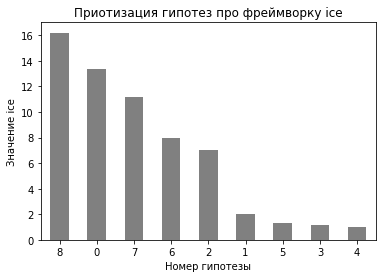

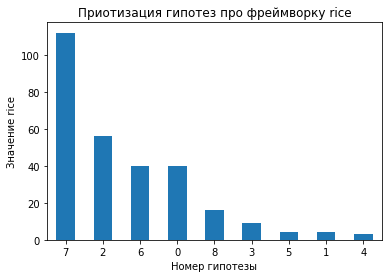

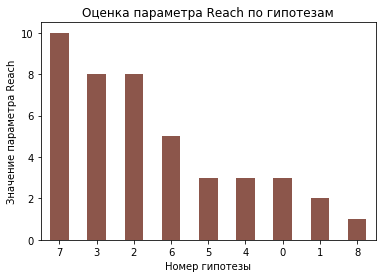

In [17]:
pd.set_option('max_colwidth', 200)
pd.options.display.max_colwidth = 150
dictionary = pd.DataFrame({'Гипотеза':hypothesis['hypothesis'],'Номер гипотезы':hypothesis.index})
display(dictionary)
#ищем фреймворк ice
hypothesis['ice'] = (hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'])
hypothesis['ice'] = hypothesis['ice'].sort_values(ascending = False).plot(y ='ice',kind = 'bar',color = 'grey')
plt.title('Приотизация гипотез про фреймворку ice')
plt.ylabel('Значение ice')
plt.xlabel('Номер гипотезы')
plt.xticks(rotation = 0)
plt.show()
#ищем фреймворк rice
hypothesis['rice'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'])
hypothesis['rice'] = hypothesis['rice'].sort_values(ascending = False).plot(y ='rice',kind = 'bar')
plt.title('Приотизация гипотез про фреймворку rice')
plt.ylabel('Значение rice')
plt.xlabel('Номер гипотезы')
plt.xticks(rotation = 0)
plt.show()
plt.title('Оценка параметра Reach по гипотезам')
hypothesis['reach'].sort_values(ascending = False).plot(kind = 'bar',color = '#8c564b')
plt.ylabel('Значение параметра Reach')
plt.xlabel('Номер гипотезы')
plt.xticks(rotation = 0)
plt.show()

### Вывод

Первые две самые приоритетные гипотезы, полученные способом `ICE` под номерами **8** и **0** потеряли свою значимость при применении способа `RICE` из-за маленькой величины охвата данных гипотез, описанной параметром `Reach`. А гипотеза под номером **2** приобрела значимость и сместилась на  второе по значимости место

## Часть 2. Анализ A/B-теста

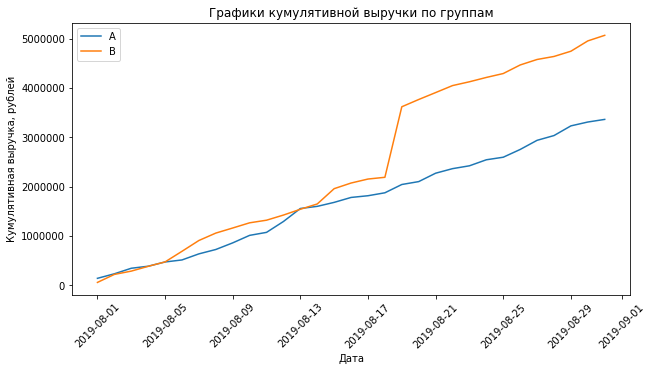

In [11]:
dateGroups = orders[['date','group']].drop_duplicates()
#создаём кумулятивную таблицу для расчёта среднего чека
ordersAggregated = dateGroups.apply(lambda x: orders[np.logical_and(orders['date']<=x['date'],orders['group'] == x['group'])]\
                                   .agg({'date':'max','group':'min','revenue':'sum','transactionId':pd.Series.nunique,
                                         'visitorId':pd.Series.nunique}),axis = 1).sort_values(by=['date','group'])
ordersAggregated = ordersAggregated.rename(columns = {'transactionId':'orders','visitorId':'buyers'})
cumulativeRevenueA = ordersAggregated[ordersAggregated['group']=='A'][['date','revenue','orders']]
cumulativeRevenueB = ordersAggregated[ordersAggregated['group']=='B'][['date','revenue','orders']]
plt.figure(figsize=(10,5))
plt.title('Графики кумулятивной выручки по группам')
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue'], label = 'B')
plt.ylabel('Кумулятивная выручка, рублей')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

### Вывод

На полученных графиках можно видеть итоговое преимущество по выручке группы  `B`, но её график при этом имеет "скачок", что скорее всего говорит о присутсвии анамальных стоимостей заказов

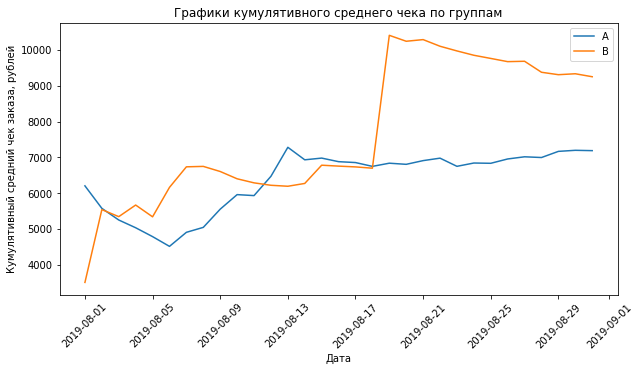

In [12]:
plt.figure(figsize=(10,5))
plt.title('Графики кумулятивного среднего чека по группам')
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label = 'B')
plt.xticks(rotation = 45)
plt.ylabel('Кумулятивный средний чек заказа, рублей')
plt.xlabel('Дата')
plt.legend()
plt.show()

### Вывод

По результатам, в начале видны колебания графиков, затем резкий "скачок" кумулятивного среднего чека у группы `B`. По итогу графики стабилизировались.

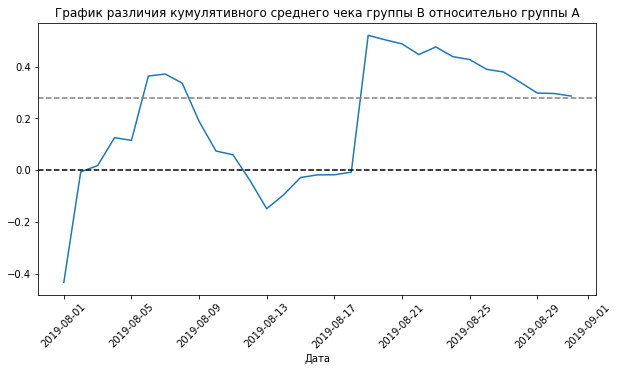

In [13]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, on = ['date'], suffixes = ['A','B'])
plt.figure(figsize=(10,5))
plt.title('График различия кумулятивного среднего чека группы B относительно группы A')
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation = 45)
plt.xlabel('Дата')
plt.axhline(y = 0, linestyle ='--', color = 'black')
plt.axhline(y = 0.28, linestyle ='--', color = 'grey')
plt.show()

### Вывод

По центральной предельной теореме значение кумулятивных метрик часто сходится и устанавливается около некоторого среднего. В данном случае относительное значение среднего чека группы `B` относительно `A` уменьшается после "скачка", в результате чего устанавливается возле среднего значения `y = 0.28`

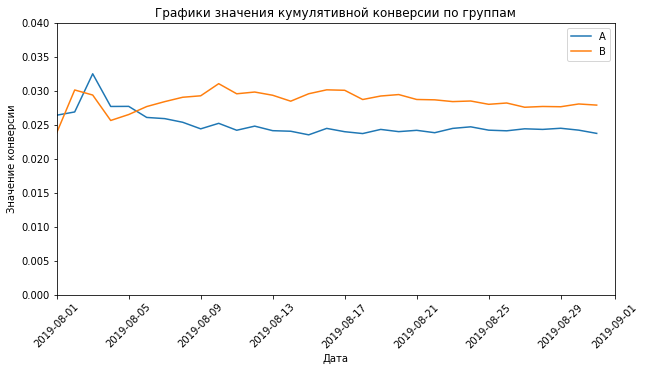

In [14]:
#создаём кумулятивную таблицу для расчёт конверсии
visitorsAggregated = visitors.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                       visitors['group'] == x['group'])]\
                                                       .agg({'date':'max','group':'max','visitors':'sum'}),axis = 1)

cumulativeData = visitorsAggregated.merge(ordersAggregated, on = ['date','group'])
cumulativeData['conversion'] = cumulativeData['buyers']/cumulativeData['visitors']
cumulativeConvA = cumulativeData[cumulativeData['group'] == 'A'][['date','conversion']]
cumulativeConvB = cumulativeData[cumulativeData['group'] == 'B'][['date','conversion']]
plt.figure(figsize=(10,5))
plt.title('Графики значения кумулятивной конверсии по группам')
plt.plot(cumulativeConvA['date'],cumulativeConvA['conversion'], label = 'A')
plt.plot(cumulativeConvB['date'],cumulativeConvB['conversion'], label = 'B')
plt.ylabel('Значение конверсии')
plt.xlabel('Дата')
plt.legend()
plt.xticks(rotation = 45)
plt.axis(["2019-08-01", '2019-09-01', 0, 0.04])
plt.show()

### Вывод

Графики стабилизировались, можно видеть, что значения кумулятивной конверсии группы `B` лучше группы `A`

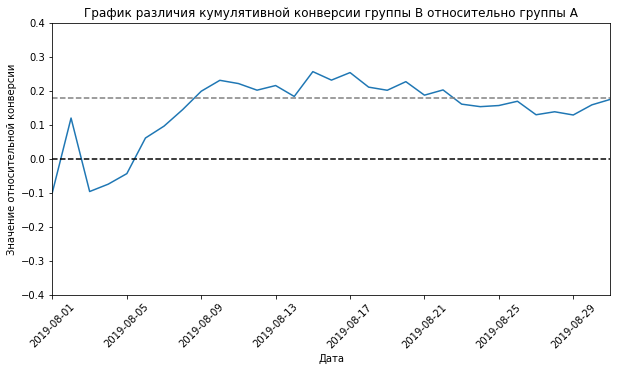

In [15]:
conversionMerged = cumulativeConvA.merge(cumulativeConvB, on = ['date'],suffixes = ['A','B'])
plt.figure(figsize = (10,5))
plt.title('График различия кумулятивной конверсии группы B относительно группы A')
plt.plot(conversionMerged['date'],conversionMerged['conversionB']/conversionMerged['conversionA'] - 1)
plt.ylabel('Значение относительной конверсии')
plt.xlabel('Дата')
plt.axis(['2019-08-01','2019-08-31',-0.4,0.4])
plt.xticks(rotation = 45)
plt.axhline(y = 0, linestyle ='--', color = 'black')
plt.axhline(y = 0.18, linestyle ='--', color = 'grey')
plt.show()

### Вывод

На графике **относительного различия** нагляднее видна разница конверсий, где кумулятивная конверсия группы `B` превосходит `A` и имеет тенденцию к росту

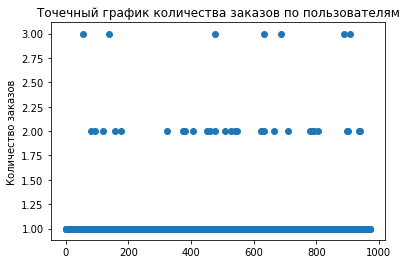

95 и 99 перцентили количества заказов по пользователям
[1. 2.]


In [16]:
ordersByVisitor = orders.groupby(['visitorId','group'],as_index = False).agg({'transactionId':'nunique','revenue':'sum'})
ordersByVisitor = ordersByVisitor.rename(columns = {'transactionId':'orders'})
plt.title('Точечный график количества заказов по пользователям')
plt.scatter(range(0,len(ordersByVisitor)),ordersByVisitor['orders'])
plt.ylabel('Количество заказов')
plt.show()
print('95 и 99 перцентили количества заказов по пользователям')
print(np.percentile(ordersByVisitor['orders'], [95,99]))

### Вывод

Пользователей, совершивших более 1 заказа принимаем за аномальных

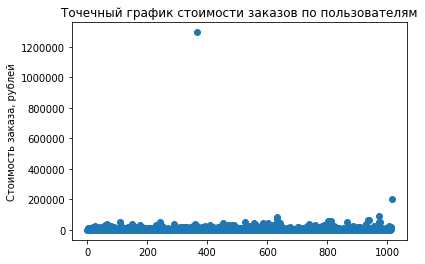

95 и 99 перцентили стоимости заказов
[26785. 53904.]


In [17]:
plt.title('Точечный график стоимости заказов по пользователям')
plt.scatter(range(0,len(orders)),y = orders['revenue'])
plt.ylabel('Стоимость заказа, рублей')
plt.show()
print('95 и 99 перцентили стоимости заказов')
print(np.percentile(orders['revenue'],[95,99]))

### Вывод

Заказы, стоимостью более 26785 рублей принимаем за аномальные

In [18]:
#создаём таблицы - количество заказов по группам
ordersByVisitorA = ordersByVisitor[ordersByVisitor['group'] == 'A']
ordersByVisitorB = ordersByVisitor[ordersByVisitor['group'] == 'B']

#создаём таблицы - количество визитов по группам
visitorsA = visitors[visitors['group'] == 'A']['visitors']
visitorsB = visitors[visitors['group'] == 'B']['visitors']

revenueByOrderA = orders[orders['group'] == 'A']
revenueByOrderB = orders[orders['group'] == 'B']
#создаём таблицы по группам: пользователь - количество заказов(учитывая пользователей, кто не делал заказ)
sampleA = pd.concat([ordersByVisitorA['orders'],
                    pd.Series(0, index = np.arange(visitorsA.sum() - len(ordersByVisitorA)),
                    name = 'orders')])
sampleB = pd.concat([ordersByVisitorB['orders'],
                    pd.Series(0, index = np.arange(visitorsA.sum() - len(ordersByVisitorB)),
                    name = 'orders')])

#ищем статистическую значимость с помощью непараметрического теста
pvalueConv = stats.mannwhitneyu(sampleA,sampleB)[1]                   
print('Статистическая значимость различия в конверсии между группами A и B с сырыми данными равна: {:.3f}'\
      .format(pvalueConv))
if pvalueConv > 0.05:
    print('Не отвергаем нулевую гипотезу, значит "между конверсиями групп А и B с сырами данными нет существенного различия"')
else:
    print('Отвергаем нулевую гипотезу, значит "между конверсиями групп А и B с сырыми данными есть различие"')
pvalueRevenue = stats.mannwhitneyu(revenueByOrderA['revenue'],
                      revenueByOrderB['revenue'])[1]
print()
print('Статистическая значимость различия в среднем чеке на товар между тестами A и B равна: {:.3f}'.format(pvalueRevenue))
if pvalueRevenue > 0.05:
    print('Не отвергаем нулевую гипотезу, значит '+ 
          '"между средними чеками заказов групп А и B с сырыми данными нет существенного различия"')
else:
    print('Отвергаем нулевую гипотезу, значит "между средними чеками заказов групп А и B с сырыми данными есть различие"')

Статистическая значимость различия в конверсии между группами A и B с сырыми данными равна: 0.004
Отвергаем нулевую гипотезу, значит "между конверсиями групп А и B с сырыми данными есть различие"

Статистическая значимость различия в среднем чеке на товар между тестами A и B равна: 0.415
Не отвергаем нулевую гипотезу, значит "между средними чеками заказов групп А и B с сырыми данными нет существенного различия"


In [19]:
#ищем visitorId аномальных пользователей, совершивших заказ больше 2 раз либо имеющих стоиомсть заказа > 28000 
anomalByRevenue = orders[orders['revenue'] > 26785]['visitorId']
anomalByOrders = ordersByVisitor[ordersByVisitor['orders'] > 1]['visitorId']
anomalUsers = pd.concat([anomalByRevenue,anomalByOrders], axis = 0).drop_duplicates() 

In [20]:
#создаём таблицы по группам, исключая анамальных пользователей: пользователь - количетсво заказов
#(учитывая пользователей, кто не делал заказ)
sampleAFiltered = pd.concat([ordersByVisitorA[np.logical_not(ordersByVisitorA['visitorId'].isin(anomalUsers))]['orders'], 
                    pd.Series(0, index = np.arange(visitorsA.sum() - len(ordersByVisitorA)),
                    name = 'orders')],axis = 0)
sampleBFiltered = pd.concat([ordersByVisitorB[np.logical_not(ordersByVisitorB['visitorId'].isin(anomalUsers))]['orders'], 
                    pd.Series(0, index = np.arange(visitorsA.sum() - len(ordersByVisitorB)),
                    name = 'orders')],axis = 0)

#создаём таблицы по группам, исключая анамальные заказы: заказ - стоиомость заказа
revenueFilteredA = revenueByOrderA[revenueByOrderA['revenue'] <= 26785]['revenue']
revenueFilteredB = revenueByOrderB[revenueByOrderB['revenue'] <= 26785]['revenue']

#ищем статистическую значимость с помощью непараметрического теста
pvalueConvFilt = stats.mannwhitneyu(sampleAFiltered,sampleBFiltered)[1]                   
print('Статистическая значимость различия в конверсии между группами A и B очищенных данных равна: {:.3f}'\
      .format(pvalueConvFilt))
if pvalueConvFilt > 0.05:
    print('Не отвергаем нулевую гипотезу, значит "между конверсиями групп А и B c очищенными данными нет существенного различия"')
else:
    print('Отвергаем нулевую гипотезу, значит "между конверсиями групп А и B c очищенными данными есть различие"')
pvalueRevenuFilt = stats.mannwhitneyu(revenueFilteredA,
                      revenueFilteredB)[1]
print()
print('Статистическая значимость различия в среднем чеке заказов между группами A и B очищенных данных равна: {:.3f}'
      .format(pvalueRevenuFilt))
if pvalueRevenuFilt > 0.05:
    print('Не отвергаем нулевую гипотезу, значит: '+
          '"между средними чеками на товар групп А и B очищенных данных нет существенного различия"')
else:
    print('Отвергаем нулевую гипотезу, значит "между средними чеками на товар групп А и B очищенных данных есть различие"')

Статистическая значимость различия в конверсии между группами A и B очищенных данных равна: 0.005
Отвергаем нулевую гипотезу, значит "между конверсиями групп А и B c очищенными данными есть различие"

Статистическая значимость различия в среднем чеке заказов между группами A и B очищенных данных равна: 0.349
Не отвергаем нулевую гипотезу, значит: "между средними чеками на товар групп А и B очищенных данных нет существенного различия"


### Вывод

- Есть статистически значимое различие между группами по конверсии и по "сырым" и по "очищенным" данным
- Нет статически значимого различия между группами по среднему чеку и по "сырым" и по "очищенным" данным 

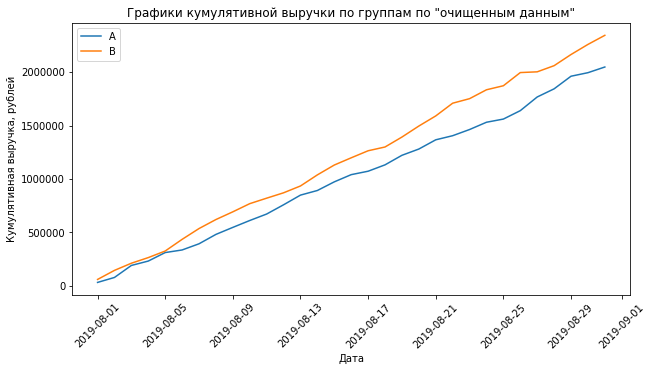

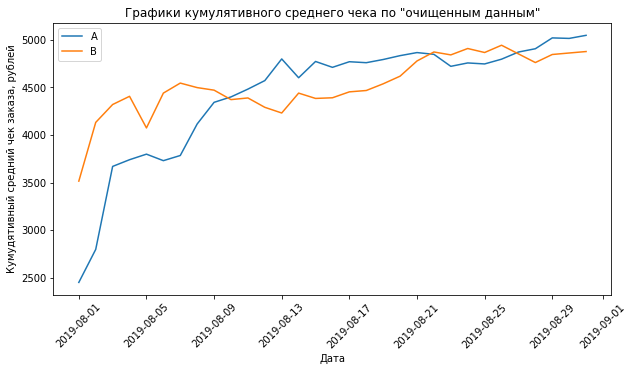

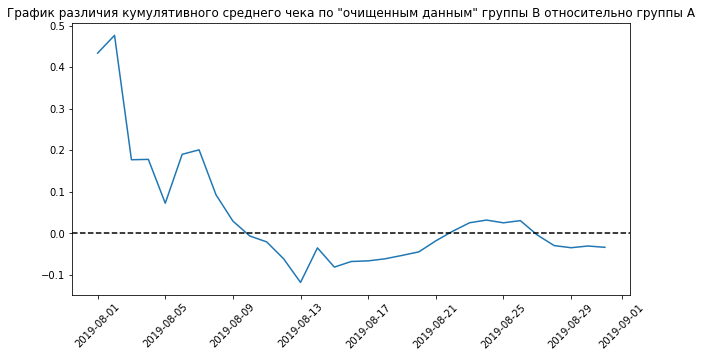

In [21]:
#строим графики по очищенным данным
orders = orders[np.logical_not(orders['visitorId'].isin(anomalUsers))]
dateGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = dateGroups.apply(lambda x: orders[np.logical_and(orders['date']<=x['date'],orders['group'] == x['group'])]\
                                   .agg({'date':'max','group':'min','revenue':'sum','transactionId':pd.Series.nunique,
                                         'visitorId':pd.Series.nunique}),axis = 1).sort_values(by=['date','group'])
ordersAggregated = ordersAggregated.rename(columns = {'transactionId':'orders','visitorId':'buyers'})
cumulativeRevenueA = ordersAggregated[ordersAggregated['group']=='A'][['date','revenue','orders']]
cumulativeRevenueB = ordersAggregated[ordersAggregated['group']=='B'][['date','revenue','orders']]
plt.figure(figsize=(10,5))
plt.title('Графики кумулятивной выручки по группам по "очищенным данным"')
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue'], label = 'B')
plt.ylabel('Кумулятивная выручка, рублей')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('Графики кумулятивного среднего чека по "очищенным данным"')
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label = 'B')
plt.xticks(rotation = 45)
plt.ylabel('Кумудятивный средний чек заказа, рублей')
plt.xlabel('Дата')
plt.legend()
plt.show()

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, on = ['date'], suffixes = ['A','B'])
plt.figure(figsize=(10,5))
plt.title('График различия кумулятивного среднего чека по "очищенным данным" группы B относительно группы A')
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation = 45)
plt.axhline(y = 0, linestyle ='--', color = 'black')
plt.show()

## Решение по результатам теста

Конверсия группы `B` стабильно больше группы `A`, имеет тенденцию к росту, при этом есть статически значимое различие между конверсиями и по "сырым" и по "очищенным" данным. Средний чек заказа по группам статически не имеет значимого различия ни по "сырым" ни по по "очищенным" данным, графики кумулятивного среднего чека сходятся к одному значению.

Решение: **остановить тест, зафиксировать победу группы `B`**


## Общий вывод
- На основе фреймворков `RICE` и `ICE`, в первую очередь следует протестировать гипотезу
**"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"**
- В период с 17 по 21 число были выбросы по стоимости заказа
- **95%** пользователей делают по `1` заказу, стоиомостью `< 26786` рублей за заказ
- Есть статистически значимое различие между группами по конверсии и по "сырым" и по "очищенным" данным
- Нет статически значимого различия между группами по среднему чеку и по "сырым" и по "очищенным" данным 
- Конверсия группы `B` превосходит `A`, значение относительной конверсии **y = 0.18**